# Fairlearn Starter Notebook


## What is Fairlearn?
---

Fairlearn is a open-source Python package developed by Microsoft. It implements algorithms to uncover issues related to fairness of groups defined in a dataset and to mitigate these with the help of specially trained machine learning.

**That's great and all but why should we even care?**

* One of the big risk that may occur with machine learning models is inherent bias towards certain groups/categories of individuals. It will be highly unethical for our model deny information, products or services to groups of people simply because of their demographics. 

* It can also lead to groups of people having lower quality of services or products and less access to information.

## Dataset
---

For this demo, we will be using a dataset pertaining to student loan approval. Imagine if a company wants to automate its loan eligibility process (real time) based on customer detail provided while filling online application form. We will first check if the dataset is biased towards any gender and find ways to mitigate gender bias.

**Dataset Description:**

| Variable | Description | 
|------|------|
| Loan_ID | Unique Loan ID | 
| Gender | Male/ Female | 
| Married | Applicant married (Y/N) | 
| Dependents | Number of dependents | 
| Education | Applicant Education (Graduate/ Under Graduate) | 
| Self_Employed | Self employed (Y/N) | 
| ApplicantIncome | Applicant income | 
| CoapplicantIncome | Coapplicant income | 
| LoanAmount | Loan amount in thousands | 
| Loan_Amount_Term | Term of loan in months | 
| Credit_History | credit history meets guidelines | 
| Property_Area | Urban/ Semi Urban/ Rural | 
| Loan_Status | Loan approved (Y/N) | 


There are 615 observations in this dataset

The dataset can be found in this link: https://www.kaggle.com/ninzaami/loan-predication

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

In [2]:
df = pd.read_csv("student_loan.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data Preparation
---
Let's do some data preparation

1. Drop irrelevant columns (Loan_ID, LoanAmount, Loan_Amount_Term)
2. Deal with missing data
3. Encode Categorical Columns

In [4]:
# Drop irrelevant columns
df.drop(columns=['Loan_ID', 'LoanAmount', 'Loan_Amount_Term'], inplace=True)

In [5]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

For simplicity, we will treat missing values as a separate category.
In the case of Gender and Married, we will drop rows with missing values

In [6]:
df = df[(~df['Gender'].isnull()) & (~df['Married'].isnull())]
df['Dependents'] = df['Dependents'].map({'0': '0',
                                         '1': '1',
                                         '2': '2',
                                         '3+': '3'})
fill_values = {'Self_Employed': 'NaN', 'Dependents': 'NaN', 'Credit_History': -1}
df.fillna(value=fill_values, inplace=True)

In [7]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
# Apply LabelEncoder on each of the categorical columns
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 
                    'Credit_History', 'Property_Area', 'Dependents', 'Loan_Status']
le = LabelEncoder()

df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [9]:
# Train test split

A = df['Gender']


X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(df.drop(columns="Loan_Status"), 
                                                                     df['Loan_Status'],
                                                                     A,
                                                                     stratify=df['Loan_Status'], 
                                                                     test_size=0.2)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train], axis=1)

**Train-Test Distribution:**

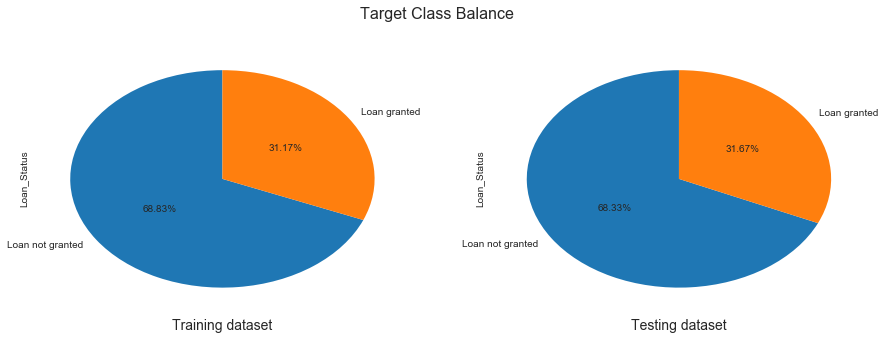

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('seaborn-white')

plt.subplot(1, 2, 1)

y_train.value_counts().plot(kind = 'pie',
                            autopct = '%.2f%%',
                            startangle = 90,
                            labels = ['Loan not granted','Loan granted'],
                            pctdistance = 0.5)

plt.xlabel('Training dataset', fontsize = 14)

plt.subplot(1, 2, 2)

y_test.value_counts().plot(kind = 'pie',
                           autopct = '%.2f%%',
                           startangle = 90,
                           labels = ['Loan not granted','Loan granted'],
                           pctdistance = 0.5)

plt.xlabel('Testing dataset', fontsize = 14)

plt.suptitle('Target Class Balance', fontsize = 16)
plt.show()

Now, let us examine the data more closely. We look at the distributions of lsat and ugpa by race (summarized via quartiles), and compare them with the bar passage rates.

In [11]:
gender_grouped = all_train.groupby('Gender')
counts_by_gender = gender_grouped[['Loan_Status']].count().rename(
    columns={'Loan_Status': 'count'})

rates_by_gender = gender_grouped[['Loan_Status']].mean().rename(
    columns={'Loan_Status': 'pass_loan_rate'})

summary_by_gender = pd.concat([counts_by_gender, rates_by_gender], axis=1)
display(summary_by_gender)

,count,pass_loan_rate
Gender,,
0,92,0.663043
1,386,0.694301


It looks like males have a slightly higher chance of getting loans that are approved

## Unmitigated Predictor
---

We first train a standard logistic regression predictor that does not seek to incorporate any notion of fairness.

In [12]:
from sklearn.linear_model import LogisticRegression

unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

To obtain the AUC values for the overall student population as well as male and female subpopulations, we use the group metric variant of the sklearn metric roc_auc_score.

In [42]:
from fairlearn.metrics import roc_auc_score_group_summary

def summary_as_df(name, summary):
    a = pd.Series(summary.by_group)
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

scores_unmitigated = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="score_unmitigated")
y_pred = (scores_unmitigated >= np.mean(y_test)) * 1
auc_unmitigated = summary_as_df(
    "auc_unmitigated", roc_auc_score_group_summary(y_test, scores_unmitigated, sensitive_features=A_test))

## Fairness of Model
---

The fairlearn package provides fairness-related metrics that can be compared between groups and for the overall population. The goal is to assure that neither of the genders has substantially larger false-positive rates or false-negative rates than the other groups. Therefore, as a protected (sensitive) feature we will set gender that has a highest impact on predictions of the trained model.

Using existing metric definitions from scikit-learn we can evaluate metrics to get a group summary. As the overall performance metric we will apply the area under ROC curve (AUC), which is suited to classification problems with a large imbalance between positive and negative examples.

As the fairness metric we will use equalized odds and demographic parity.

* DemographicParity: this metric states that the proportion of each segment of a protected feature (e.g. gender) should receive the positive outcome at equal rates.

* EqualisedOdds this metric states that the model should correctly identify the positive outcome at equal rates across groups, but also miss-classify the positive outcome at equal rates across groups (creating the same proportion of False Positives across groups).

In [14]:
from fairlearn.metrics import (
    group_summary, selection_rate, selection_rate_group_summary,
    demographic_parity_difference, demographic_parity_ratio,
    balanced_accuracy_score_group_summary, roc_auc_score_group_summary,
    equalized_odds_difference, difference_from_summary)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score


# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "-----": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: difference_from_summary(
                balanced_accuracy_score_group_summary(y_true, x, sensitive_features=group)), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: difference_from_summary(
                roc_auc_score_group_summary(y_true, x, sensitive_features=group)), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [15]:
models_dict = {"Unmitigated": (y_pred, scores_unmitigated)}
get_metrics_df(models_dict, y_test, A_test)

,Unmitigated
Overall selection rate,0.791667
Demographic parity difference,0.127671
Demographic parity ratio,0.842747
-----,
Overall balanced error rate,0.363607
Balanced error rate difference,0.00215998
Equalized odds difference,0.12932
------,
Overall AUC,0.737965
AUC difference,0.0547485


The difference in accuracy rates (as indicated by the balanced error rate difference) seems to be slight between males and females, which shows little bias in the unmitigated predictions. 

We can also analyze AUC and selection rate for each gender as shown below.

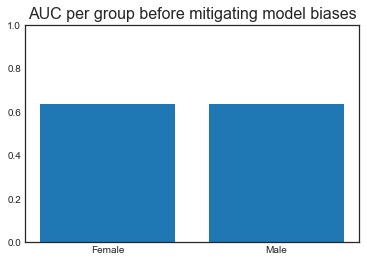

In [16]:
gs = group_summary(roc_auc_score, y_test, y_pred, sensitive_features=A_test)
gs

plt.figure()
plt.style.use('seaborn-white')
plt.title("AUC per group before mitigating model biases", fontsize = 16)
plt.bar(range(len(gs["by_group"])), list(gs["by_group"].values()), align='center')
plt.xticks(range(len(gs["by_group"])), ['Female', 'Male'])
plt.ylim(0, 1)
plt.show()

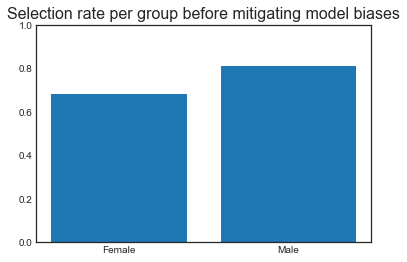

In [17]:
srg = selection_rate_group_summary(y_test, y_pred, sensitive_features=A_test)

plt.figure()
plt.style.use('seaborn-white')
plt.title("Selection rate per group before mitigating model biases", fontsize = 16)
plt.bar(range(len(srg["by_group"])), list(srg["by_group"].values()), align='center')
plt.xticks(range(len(srg["by_group"])), ['Female', 'Male'])
plt.ylim(0, 1)
plt.show()

## Fairlearn Dashboard
---

More details can be found in the Fairlearn Dashboard

In [18]:
from fairlearn.widget import FairlearnDashboard

FairlearnDashboard(sensitive_features=A_test, sensitive_feature_names=['Gender'],
                   y_true=y_test,
                   y_pred={"Unmitigated": y_pred})

FairlearnWidget(value={'true_y': [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0…

## Mitigating Discrimination with Fairlearn
---

* We can mitigate the demographic disparity using the GridSearch algorithm of Fairlearn. We will use this algorithm to obtain several models that achieve various trade-offs between accuracy (measured by AUC) and demographic disparity.

* GridSearch generates models corresponding to various Lagrange multiplier vectors of the underlying constraint optimization problem. We will compute 200 models on a grid of Lagrange multiplier vectors whose L1-norm is bounded by 10. 

For more details, refer to:
https://github.com/fairlearn/fairlearn/blob/master/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

In [34]:
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.calibration import CalibratedClassifierCV

sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=200,
                   grid_limit=10)

sweep.fit(X_train, y_train, sensitive_features=A_train)

calibrated_predictors = []
for predictor in sweep._predictors:
    calibrated = CalibratedClassifierCV(base_estimator=predictor, cv='prefit', method='sigmoid')
    calibrated.fit(X_train, y_train)
    calibrated_predictors.append(calibrated)

Let's assess the accuracy and disparity of the obtained predictors in a scatter plot, with x axis showing the worst-case AUC among the two subpopulations (of male and female students) and y axis showing the demographic disparity. Ideal models would be in the bottom right.

In [37]:
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities


def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.xlabel(data.name)
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

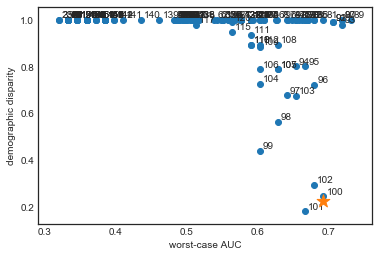

In [36]:
from fairlearn.metrics import roc_auc_score_group_min

def auc_disparity_sweep_plot(predictors, names, marker='o', scale_size=1, zorder=-1):
    roc_auc = np.zeros(len(predictors))
    disparity = np.zeros(len(predictors))
    
    for i in range(len(predictors)):
        preds = predictors[i].predict_proba(X_test)[:,1]
        roc_auc[i] = roc_auc_score_group_min(y_test, preds, sensitive_features=A_test)
        _, _, dis = compare_cdfs(preds, A_test)
        disparity[i] = dis.max()
        
    plt.scatter(roc_auc, disparity,
                s=scale_size * plt.rcParams['lines.markersize'] ** 2, marker=marker, zorder=zorder)
    for i in range(len(roc_auc)):
        plt.annotate(names[i], (roc_auc[i], disparity[i]), xytext=(3,2), textcoords="offset points", zorder=zorder+1)
    plt.xlabel("worst-case AUC")
    plt.ylabel("demographic disparity")
    
auc_disparity_sweep_plot(calibrated_predictors, names=range(len(calibrated_predictors)))
auc_disparity_sweep_plot([unmitigated_predictor], names=[''], marker='*', zorder=1, scale_size=5)
plt.show()

Model 101 has the lowest disparity, but its worst-case AUC is worse than the unmitigated model. The unmitigated model, marked as a star, has a good worst-case AUC, but larger disparity. We examine models 101: its AUC value is well above 0.6 and it substantially reduce the demographic disparity compared with the unmitigated model:

,auc_model101,auc_unmitigated
0,0.666667,0.692308
1,0.719882,0.747056
overall,0.711650,0.737965


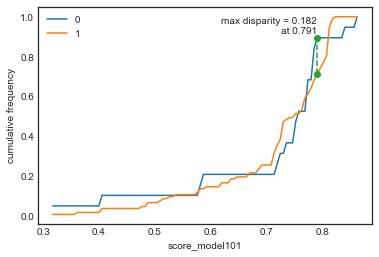

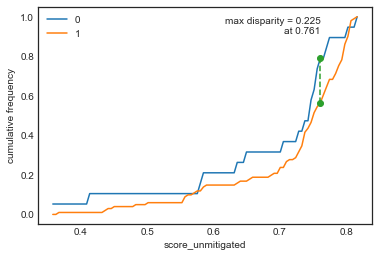

In [51]:
# a convenience function that transforms the result of a group metric call into a data frame

scores_model101 = pd.Series(calibrated_predictors[101].predict_proba(X_test)[:,1], name="score_model101")

auc_model101 = summary_as_df(
        "auc_model101", roc_auc_score_group_summary(y_test, scores_model101, sensitive_features=A_test))

display(HTML('<span id="grid_search_comparison">'),
        pd.concat([auc_model101, auc_unmitigated], axis=1),
        HTML('</span>'))
plot_and_compare_cdfs(scores_model101, A_test.reset_index(drop=True))
plot_and_compare_cdfs(scores_unmitigated, A_test.reset_index(drop=True))

Clearly Model 101 has less disparity between the genders for all thresholds

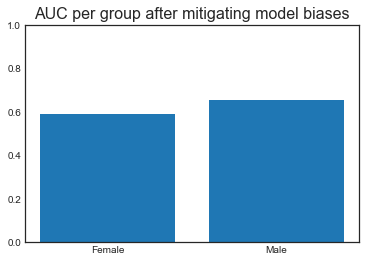

In [52]:
y_pred_mitigated = (scores_model101 >= np.mean(y_test)) * 1

gs = group_summary(roc_auc_score, y_test, y_pred_mitigated, sensitive_features=A_test)
gs

plt.figure()
plt.style.use('seaborn-white')
plt.title("AUC per group after mitigating model biases", fontsize = 16)
plt.bar(range(len(gs["by_group"])), list(gs["by_group"].values()), align='center')
plt.xticks(range(len(gs["by_group"])), ['Female', 'Male'])
plt.ylim(0, 1)
plt.show()

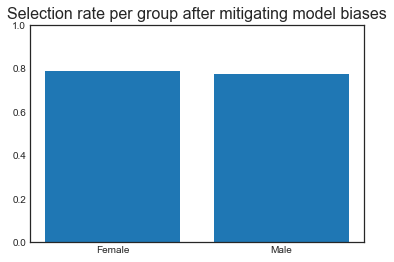

In [53]:
srg = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=A_test)

plt.figure()
plt.style.use('seaborn-white')
plt.title("Selection rate per group after mitigating model biases", fontsize = 16)
plt.bar(range(len(srg["by_group"])), list(srg["by_group"].values()), align='center')
plt.xticks(range(len(srg["by_group"])), ['Female', 'Male'])
plt.ylim(0, 1)
plt.show()

We have managed to successfully trained a model that reduces disparity between the genders (albeit trading off model performance in the process)

## Acknowledgements
---

* Fairlearn github repo (for code to get started with fairlearn) :

https://github.com/fairlearn/fairlearn/blob/master/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

* Excellent kaggle kernel which shows how to plot visualizations from outputs of fairlearn:

https://www.kaggle.com/liananapalkova/fairlearn-open-source-python-package-of-microsoft